In [110]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from copy import copy
import joblib
import random
import numpy as np
from scipy.stats import linregress
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from syd import make_viewer
from tqdm import tqdm
from rastermap import Rastermap
import optuna

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, sort_by_preferred_environment, edge2center, beeswarm, format_spines, insert_nans_at_gaps, save_figure
from vrAnalysis.sessions import B2Session, SpksTypes
from vrAnalysis.processors import SpkmapProcessor
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior, get_placefield_prediction
from dimilibi import Population
from dimilibi import ReducedRankRegression, RidgeRegression
from dimilibi import measure_r2, mse
from dimensionality_manuscript.registry import PopulationRegistry, get_model, ModelName, short_model_name
from dimensionality_manuscript.regression_models.hyperparameters import PlaceFieldHyperparameters, RBFPosHyperparameters, ReducedRankRegressionHyperparameters
from dimensionality_manuscript.workflows.pf1d_internals import get_filepath as get_pf1d_internals_filepath
from dimensionality_manuscript.workflows.rrrlatents_to_rbfpos import get_filepath as get_rrrlatents_to_rbfpos_filepath

plt.rcParams["font.size"] = 18

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()
ext_model = get_model("external_placefield_1d", registry)
int_model = get_model("internal_placefield_1d", registry)
ext_gain_model = get_model("external_placefield_1d_gain", registry)
int_gain_model = get_model("internal_placefield_1d_gain", registry)
rbfpos_decoder_only_model = get_model("rbfpos_decoder_only", registry)
rbfpos_model = get_model("rbfpos", registry)
rbfpos_leak_model = get_model("rbfpos_leak", registry)
rrr_model = get_model("rrr", registry)

In [3]:
# 0. Why is RBFPos the worst? 
# 0. Why isn't gain helping? 
# 0. Check to make sure best hyperparameters aren't at edges of grid!
# ----------------------------
# 1. I'll just analyze the results, let's make the r2 plots across models, averaging each mouse
# 3. Then make the auxiliary plots for the models, showing what they do etc beyond the schematic

# Plot Structure:
# - for each model, show predictions (using a session with average performance? or same session throughout?)
# - show any internals of the model where relevant
# - for RRR, analyze how the RRR latents contain the spatial information or not. Probably using RidgeRegression in both directions.
# - for RRR look at the difference between the RRR and 1DPF model to try to understand why it's better. Maybe make a covariance matrix
#   of the deviations to look at clusters of cells that it's detecting together? Then potentially do rastermap on the deviations? 
# - basically I'd really like to find some way of visualizing the improvement in performance of the RRR model...

100%|██████████| 149/149 [00:20<00:00,  7.18it/s]


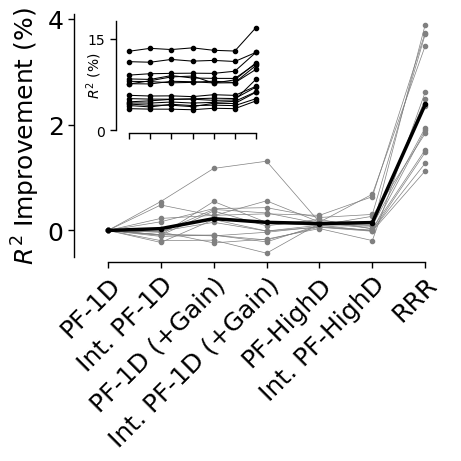

In [111]:
# Overall performance across models - mouse average of R2
MODEL_NAMES: list[ModelName] = [
    "external_placefield_1d",
    "internal_placefield_1d",
    "external_placefield_1d_gain",
    "internal_placefield_1d_gain",
    "rbfpos_decoder_only",
    "rbfpos",
    "rbfpos_leak",
    "rrr",
]
models = [get_model(model_name, registry) for model_name in MODEL_NAMES]

spks_type = "oasis"
sessiondb = get_database("vrSessions")
registry = PopulationRegistry()

num_sessions = len(sessiondb.iter_sessions(imaging=True))
mouse_names = []
scores = np.full((len(MODEL_NAMES), num_sessions), np.nan)
for isession, session in enumerate(tqdm(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))):
    mouse_names.append(session.mouse_name)
    for imodel, model in enumerate(models):
        metrics = model.get_best_score(session, spks_type=spks_type, method="best")
        scores[imodel, isession] = metrics["r2"]
mouse_names = np.array(mouse_names)

mice = list(set(mouse_names))
avg_scores = np.full((len(MODEL_NAMES), len(mice)), np.nan)
for imodel, model_name in enumerate(MODEL_NAMES):
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse} with model {model_name}")
        avg_scores[imodel, imouse] = np.mean(scores[imodel, mouse_names == mouse])


relative_scores = 100 * (avg_scores - avg_scores[0])

idx_keep = [0, 1, 2, 3, 4, 6, 7]
idx_show = [0, 1, 2, 3, 4, 6, 7]
ylims_improvement = [-0.5, 4.1]
ylims_r2 = [0, 18]
num_keep = len(idx_keep)
for ishow in [num_keep]: #range(num_keep): #[0, num_keep]: #range(num_keep):
    idx_show = idx_keep[:ishow+1]
    names = [short_model_name(MODEL_NAMES[i]) for i in idx_keep]

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), layout="constrained")
    ax.plot(range(len(idx_show)), relative_scores[idx_show], color="gray", linewidth=0.5, marker=".")
    ax.plot(range(len(idx_show)), np.mean(relative_scores[idx_show], axis=1), color="k", linewidth=2.5, marker=".")
    ax.set_xlim(-0.5, len(idx_keep) - 0.5)
    ax.set_ylim(ylims_improvement)
    format_spines(ax, x_pos=-0.02, y_pos=-0.02, xbounds=(0, len(idx_show) - 1), ybounds=ylims_improvement)
    ax.set_xticks(range(len(idx_keep)), labels=names, rotation=45, rotation_mode="anchor", ha="right")
    ax.set_ylabel("$R^2$ Improvement (%)")

    for itick, tick in enumerate(ax.xaxis.get_major_ticks()):
        if itick < len(idx_show):
            tick.tick1line.set_alpha(1.0)
            tick.tick2line.set_alpha(1.0)
        else:
            tick.tick1line.set_alpha(0.0)
            tick.tick2line.set_alpha(0.0)

    for ibl,lbl in enumerate(ax.get_xticklabels()):
        if ibl < len(idx_show):
            lbl.set_alpha(1.0)
        else:
            lbl.set_alpha(0.0)

    inset = ax.inset_axes([0.1, 0.52, 0.4, 0.45])
    inset.plot(range(len(idx_show)), 100 * avg_scores[idx_show], color="k", linewidth=0.75, marker=".")
    inset.set_xticks(range(len(idx_show)), labels=[], rotation=45, rotation_mode="anchor", ha="right")
    inset.set_xlim(-0.5, len(idx_keep) - 0.5)
    inset.set_ylim(ylims_r2)
    format_spines(inset, x_pos=-0.02, y_pos=-0.02, xbounds=(0, len(idx_show) - 1), ybounds=ylims_r2)
    inset.set_yticks([0, 15], labels=[0, 15], fontsize=10)
    inset.set_ylabel("$R^2$ (%)", fontsize=10, labelpad=-12)

    figure_path = registry.registry_paths.figure_path / "model_performance" / f"model_performance_r2_{ishow}"
    # save_figure(fig, figure_path)
    plt.show()

In [112]:
# Hyperparameters in models
MODEL_NAMES: list[ModelName] = [
    "external_placefield_1d",
    "internal_placefield_1d",
    "external_placefield_1d_gain",
    "internal_placefield_1d_gain",
    "rbfpos_decoder_only",
    "rbfpos",
    "rbfpos_leak",
    "rrr",
]
MODEL_HYP_LOOKUP = {
    "external_placefield_1d": ("num_bins", "smooth_width"),
    "internal_placefield_1d": ("num_bins", "smooth_width"),
    "external_placefield_1d_gain": ("num_bins", "smooth_width"),
    "internal_placefield_1d_gain": ("num_bins", "smooth_width"),
    "rbfpos_decoder_only": ("num_basis", "basis_width"),
    "rbfpos": ("num_basis", "basis_width"),
    "rbfpos_leak": ("num_basis", "basis_width"),
    "rrr": ("rank", None),
}
models = [get_model(model_name, registry) for model_name in MODEL_NAMES]


spks_type = "oasis"
sessiondb = get_database("vrSessions")
registry = PopulationRegistry()

num_sessions = len(sessiondb.iter_sessions(imaging=True))
mouse_names = []
hyp_dimensions = np.full((len(MODEL_NAMES), num_sessions), np.nan)
hyp_smoothing = np.full((len(MODEL_NAMES), num_sessions), np.nan)
for isession, session in enumerate(tqdm(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))):
    mouse_names.append(session.mouse_name)
    for imodel, model in enumerate(models):
        model_name = MODEL_NAMES[imodel]
        hyperparameters = model.get_best_hyperparameters(session, spks_type=spks_type, method="best")[0]
        if MODEL_HYP_LOOKUP[model_name][0] is not None:
            hyp_dimensions[imodel, isession] = getattr(hyperparameters, MODEL_HYP_LOOKUP[model_name][0])
        if MODEL_HYP_LOOKUP[model_name][1] is not None:
            hyp_smoothing[imodel, isession] = getattr(hyperparameters, MODEL_HYP_LOOKUP[model_name][1])
mouse_names = np.array(mouse_names)

mice = list(set(mouse_names))
avg_dimensions = np.full((len(MODEL_NAMES), len(mice)), np.nan)
avg_smoothing = np.full((len(MODEL_NAMES), len(mice)), np.nan)
for imodel, model_name in enumerate(MODEL_NAMES):
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse} with model {model_name}")
        avg_dimensions[imodel, imouse] = np.mean(hyp_dimensions[imodel, mouse_names == mouse])
        avg_smoothing[imodel, imouse] = np.mean(hyp_smoothing[imodel, mouse_names == mouse])

100%|██████████| 149/149 [00:16<00:00,  8.81it/s]


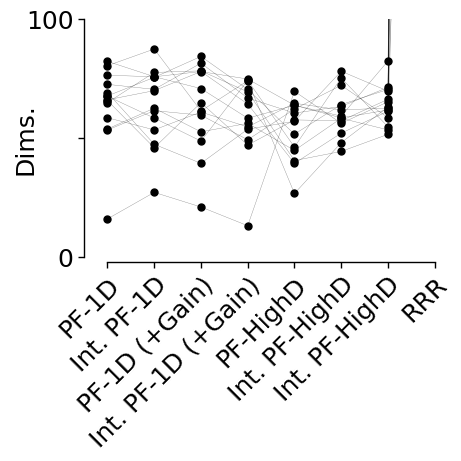

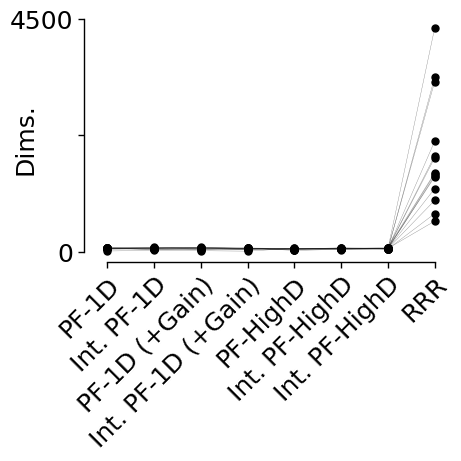

In [127]:
names = [short_model_name(MODEL_NAMES[i]) for i in range(len(MODEL_NAMES))]

for ylims in [[0, 100], [-100, 4500]]:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), layout="constrained")
    ax.plot(range(len(MODEL_NAMES)), avg_dimensions, color="k", linestyle="none", marker=".", markersize=10)
    ax.plot(range(len(MODEL_NAMES)), avg_dimensions, color="k", linewidth=0.25, alpha=0.5)
    ax.set_ylim(ylims)
    format_spines(
        ax,
        x_pos=-0.02,
        y_pos=-0.02,
        spines_visible=["left", "bottom"],
        xbounds=[0, len(MODEL_NAMES) - 1],
        ybounds=[0, ylims[1]],
    )
    ax.set_xticks(range(len(MODEL_NAMES)), labels=names, rotation=45, rotation_mode="anchor", ha="right")
    yticks = [0, ylims[1] / 2, ylims[1]]
    ylabels = [0, 4500, ylims[1]]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    for ilbl, lbl in enumerate(ax.get_yticklabels()):
        if ilbl == 1:
            lbl.set_alpha(0.0)
    ax.set_ylabel("Dims.", labelpad=-20)

    figure_path = registry.registry_paths.figure_path / "hyperparam_dimensions" / f"hyperparam_dimensions_{ylims[0]}_{ylims[1]}"
    save_figure(fig, figure_path)
    plt.show()

In [86]:
# Example data for internal placefield model & gain model
# Also with RBFPos models

mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = B2Session.create(mouse_name, date, session_id, dict(spks_type=spks_type))

# Model internals for internal placefield model & gain model
hyperparameters = int_gain_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report = int_gain_model.process(session, spks_type="oasis", hyperparameters=hyperparameters)

# get population object for this session and measure max to rescale
population = int_gain_model.registry.get_population(session, spks_type="oasis")[0]
max_activity = torch.max(population.data[population.cell_split_indices[1]], dim=1).values.numpy()

# Get reliability of ROIs
reliability = SpkmapProcessor(session).get_reliability(use_session_filters=False).filter_rois(population.idx_neurons)

show_reliable_only = False
if show_reliable_only:
    # Haven't implemented! Probs don't need to now that I'm indexing correctly :)
    pass

use_pfs_to_sort = True
if use_pfs_to_sort:
    idx_rois = population.get_split_cells("target", within_idx_neurons=True)
    idx_sort = sort_by_preferred_environment(SpkmapProcessor(session), use_session_filters=False, idx_rois=idx_rois)
else:
    idx_rois = population.get_split_cells("target", within_idx_neurons=True)
    rastermap = Rastermap(n_PCs=50, n_clusters=25, locality=0.75, time_lag_window=2)
    rastermap.fit(population.data[idx_rois].numpy())
    idx_sort = rastermap.isort

num_rois, num_frames = report.target_data.shape
extent = [0, num_frames, 0, num_rois]

position_by_environment = report.extras["frame_behavior"].position_by_environment()
position_by_environment_internal = report.extras["frame_behavior_internal"].position_by_environment()
num_env = position_by_environment.shape[0]
max_pos = session.env_length[0]
positions = np.nansum(position_by_environment + max_pos * np.arange(num_env)[:, None], axis=0)
positions_internal = np.nansum(position_by_environment_internal + max_pos * np.arange(num_env)[:, None], axis=0)

activity_variance = torch.sum(report.target_data, axis=0)
activity_variance = (activity_variance - activity_variance.mean()) / activity_variance.std()

split = registry.time_split["test"]
idx_splits = population.get_split_times(split)
gapped_positions, idx = insert_nans_at_gaps(positions, idx_splits, keep_idx=False)
gapped_positions_internal = insert_nans_at_gaps(positions_internal, idx_splits, keep_idx=False)[0]

# Model internals for RBFPos models
hyperparameters = rbfpos_decoder_only_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_decoder = rbfpos_decoder_only_model.process(session, spks_type="oasis", hyperparameters=hyperparameters)
hyperparameters = rbfpos_leak_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_leak = rbfpos_leak_model.process(session, spks_type="oasis", hyperparameters=hyperparameters)

position_basis = report_decoder.extras["position_basis"]
position_basis_leak = report_leak.extras["position_basis"]
position_basis_prediction = report_leak.extras["position_basis_predicted"]
if report_leak.extras["predictions_were_filtered"]:
    idx_valid_predictions = report_leak.extras["idx_valid_predictions"]
    position_basis_prediction = position_basis_prediction[idx_valid_predictions]
extent_decoder = [0, num_frames, 0, position_basis.shape[1]]
extent_leak = [0, num_frames, 0, position_basis_leak.shape[1]]
basis_per_env = position_basis.shape[1] // num_env
basis_per_env_leak = position_basis_leak.shape[1] // num_env

# Plotting
models = [ext_model, int_model, int_gain_model, rbfpos_decoder_only_model, rbfpos_leak_model, rrr_model]
predictions = []
reports = []
for model in models:
    hyps = model.get_best_hyperparameters(session, spks_type="oasis", method="best")
    _report = model.process(session, spks_type="oasis", hyperparameters=hyps[0])
    predictions.append(_report.predicted_data)
    reports.append(_report)

In [88]:
reports[5].extras["latents"].shape

(200, 686)

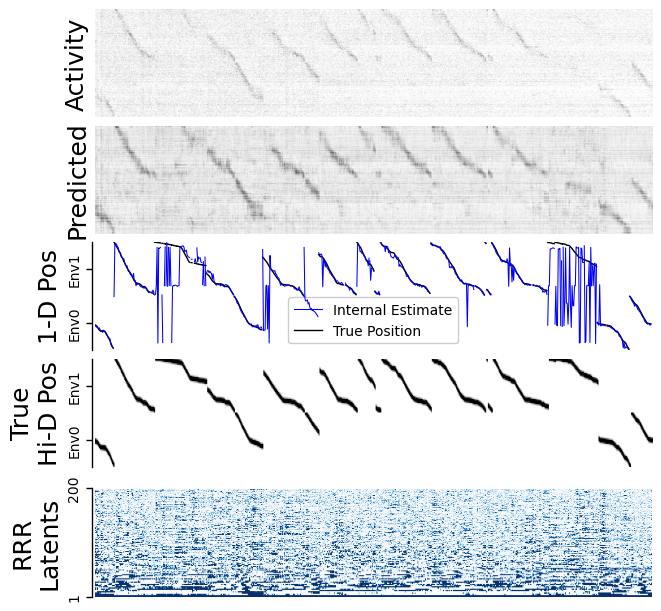

In [ ]:
include_internal_1D_min_idx = 1
num_predictions = len(predictions)
for ipred, prediction in enumerate(predictions):
    include_internal_1D = ipred >= include_internal_1D_min_idx
    vmax = 0.03
    plt.close('all')
    fig, ax = plt.subplots(5, 1, figsize=(6.5, 6), layout="constrained", sharex=True, height_ratios=[1.5, 1.5, 1.5, 1.5, 1.5])
    ax[0].imshow(report.target_data[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent)
    ax[1].imshow(prediction[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent)
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[3].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[2].set_yticks([])
    ax[3].set_yticks([])
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Predicted")
    for spine in ax[0].spines.values():
        spine.set_visible(False)
    for spine in ax[1].spines.values():
        spine.set_visible(False)

    # True and internal position
    if include_internal_1D:
        ax[2].plot(idx, gapped_positions_internal, color="b", linewidth=0.75, label="Internal Estimate", zorder=10)
    ax[2].plot(idx, gapped_positions, color="k", linewidth=1.0, label="True Position")
    ax[2].set_ylim(max_pos * num_env, 0)
    format_spines(ax[2], x_pos=-0.005, y_pos=0, spines_visible=["left"])
    ax[2].set_yticks([max_pos/2 + ienv * max_pos for ienv in range(num_env)])
    ax[2].set_yticklabels(reversed([f"Env{ienv}" for ienv in range(num_env)]), rotation=90, ha="right", va="center", fontsize=10)
    ax[2].set_ylabel("1-D Pos")
    ax[2].legend(loc="lower center", fontsize=10, framealpha=1.0)

    if ipred != 2:
        ax[3].imshow(position_basis.T, aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent_decoder)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
        ax[3].set_ylabel("True\nHi-D Pos")
        format_spines(ax[3], x_pos=-0.005, y_pos=0, spines_visible=["left"])
        ax[3].set_yticks([basis_per_env/2 + ienv * basis_per_env for ienv in range(num_env)])
        ax[3].set_yticklabels([f"Env{ienv}" for ienv in range(num_env)], rotation=90, ha="right", va="center", fontsize=10)

    else:
        ax[3].plot(report.extras["gain"], color="k", linewidth=1.0)
        ax[3].set_ylim(0, 2)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
        ax[3].set_ylabel("Gain")
        format_spines(ax[3], x_pos=-0.005, y_pos=0, spines_visible=["left"])
        ax[3].set_yticks([0, 1, 2])
        ax[3].set_yticklabels([0, 1, 2], fontsize=10)

    if ipred == 5:
        num_latents = reports[ipred].extras["latents"].shape[0]
        extent_latents = copy(extent_leak)
        extent_latents[2] = 1
        extent_latents[3] = np.log(num_latents)
        ax[4].imshow(np.flipud(reports[ipred].extras["latents"]), aspect="auto", cmap="Blues", vmin=0, vmax=vmax, extent=extent_latents)
        ax[4].set_yscale('log')
        ax[4].set_xticks([])
        ax[4].set_yticks([])
        ax[4].set_yticklabels([])
        ax[4].yaxis.set_major_locator(mpl.ticker.NullLocator())
        ax[4].yaxis.set_minor_locator(mpl.ticker.NullLocator()) 
        ax[4].set_ylabel("RRR\nLatents")
        format_spines(ax[4], x_pos=-0.005, y_pos=0, spines_visible=["left"])
        ax[4].set_yticks([extent_latents[2], extent_latents[3]])
        ax[4].set_yticklabels([1, num_latents], rotation=90, ha="right", va="center", fontsize=10)
        
    else:
        ax[4].imshow(position_basis_prediction.T, aspect="auto", cmap="Blues", vmin=0, vmax=vmax, extent=extent_leak)
        ax[4].set_xticks([])
        ax[4].set_yticks([])
        ax[4].set_ylabel("Internal\nHi-D Pos")
        format_spines(ax[4], x_pos=-0.005, y_pos=0, spines_visible=["left"])
        ax[4].set_yticks([basis_per_env_leak/2 + ienv * basis_per_env_leak for ienv in range(num_env)])
        ax[4].set_yticklabels([f"Env{ienv}" for ienv in range(num_env)], rotation=90, ha="right", va="center", fontsize=10)

    name = f"prediction_example_{ipred}"
    figure_path = registry.registry_paths.figure_path / "prediction_example" / name
    # save_figure(fig, figure_path)

    plt.show()

In [4]:
# Gather data from internal + gain placefield models on how they perform
# and how they estimate internal latent variables

spks_type = "oasis"
bins = np.linspace(-100, 100, 101)

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
num_bins = len(bins) - 1
dev_bin_counts = np.full((num_sessions, num_bins), np.nan)
fraction_switch_env = np.full((num_sessions,), np.nan)
r2_gain_target = np.full((num_sessions,), np.nan)
r2_gain_source = np.full((num_sessions,), np.nan)
slope_gain_source = np.full((num_sessions,), np.nan)
yint_gain_source = np.full((num_sessions,), np.nan)
slope_gain_target = np.full((num_sessions,), np.nan)
yint_gain_target = np.full((num_sessions,), np.nan)
for isession, session in enumerate(tqdm(session_iterable)):
    mouse_names.append(session.mouse_name)
    internals_fpath = get_pf1d_internals_filepath(session)
    if internals_fpath.exists():
        internals = joblib.load(internals_fpath)
    else:
        print(f"Measuring internals for {session.session_print()}")
        internals = int_gain_model.measure_internals(session, spks_type=spks_type, dev_bin_edges=bins)
        joblib.dump(internals, internals_fpath)
    
    dev_bin_counts[isession] = internals["dev_bin_counts"]
    fraction_switch_env[isession] = internals["fraction_switch_env"]
    r2_gain_target[isession] = internals["r2_gain_target"]
    r2_gain_source[isession] = internals["r2_gain_source"]
    slope_gain_source[isession] = internals["slope_gain_source"]
    yint_gain_source[isession] = internals["yint_gain_source"]
    slope_gain_target[isession] = internals["slope_gain_target"]
    yint_gain_target[isession] = internals["yint_gain_target"]
    session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_dev_bin_counts = np.full((num_bins, len(mice)), np.nan)
avg_fraction_switch_env = np.full((len(mice),), np.nan)
avg_r2_gain_target = np.full((len(mice),), np.nan)
avg_r2_gain_source = np.full((len(mice),), np.nan)
avg_slope_gain_source = np.full((len(mice),), np.nan)
avg_yint_gain_source = np.full((len(mice),), np.nan)
avg_slope_gain_target = np.full((len(mice),), np.nan)
avg_yint_gain_target = np.full((len(mice),), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_dev_bin_counts[:, imouse] = np.mean(dev_bin_counts[mouse_names == mouse], axis=0)
    avg_fraction_switch_env[imouse] = np.mean(fraction_switch_env[mouse_names == mouse])
    avg_r2_gain_target[imouse] = np.mean(r2_gain_target[mouse_names == mouse])
    avg_r2_gain_source[imouse] = np.mean(r2_gain_source[mouse_names == mouse])
    avg_slope_gain_source[imouse] = np.mean(slope_gain_source[mouse_names == mouse])
    avg_yint_gain_source[imouse] = np.mean(yint_gain_source[mouse_names == mouse])
    avg_slope_gain_target[imouse] = np.mean(slope_gain_target[mouse_names == mouse])
    avg_yint_gain_target[imouse] = np.mean(yint_gain_target[mouse_names == mouse])

100%|██████████| 149/149 [00:01<00:00, 99.91it/s] 


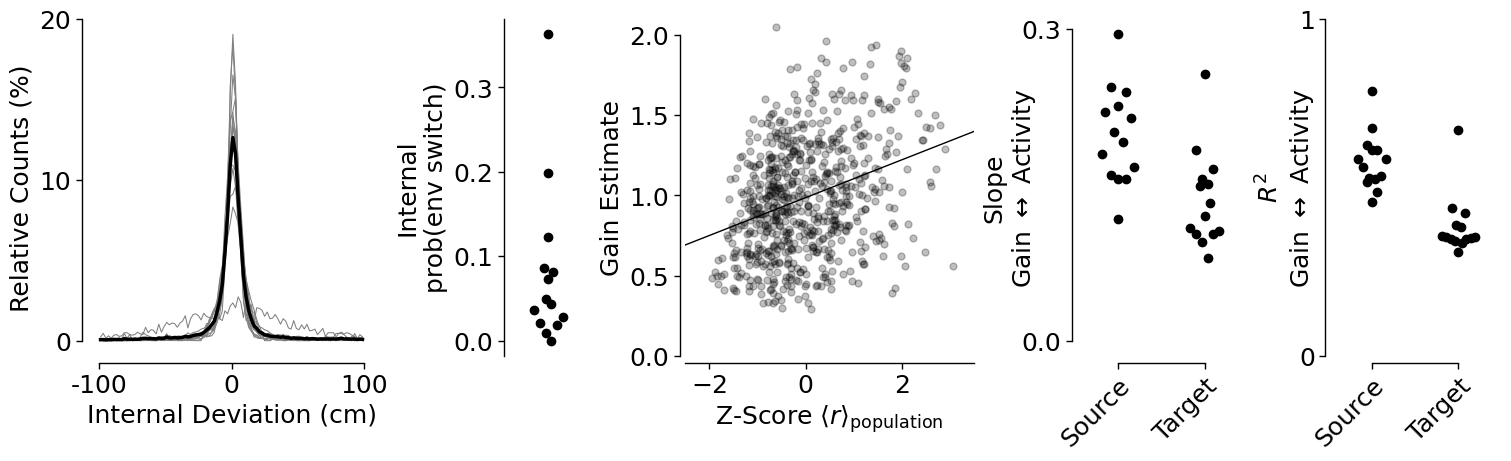

In [16]:
bee_width = 0.1
relative_counts = 100*avg_dev_bin_counts / np.sum(avg_dev_bin_counts, axis=0)
max_counts = np.max(relative_counts)
fig, ax = plt.subplots(1, 5, figsize=(15, 4.5), width_ratios=[1, 0.3, 1, 0.6, 0.6], layout="constrained")
ax[0].plot(edge2center(bins), relative_counts, color="gray", linewidth=0.75)
ax[0].plot(edge2center(bins), np.mean(relative_counts, axis=1), color="k", linewidth=2.5)
format_spines(
    ax[0],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(bins[0], bins[-1]),
    ybounds=(0, max_counts*1.05),
)
xticks = [int(bins[0]), 0, int(bins[-1])]
yticks = [0, 10, 20]
ax[0].set_xticks(xticks, labels=xticks)
ax[0].set_yticks(yticks, labels=yticks)
ax[0].set_xlabel("Internal Deviation (cm)")
ax[0].set_ylabel("Relative Counts (%)")


ax[1].plot(bee_width * beeswarm(avg_fraction_switch_env, nbins=10), avg_fraction_switch_env, color="k", linestyle="none", marker="o")
ax[1].set_xlim(-0.25, 0.25)
format_spines(
    ax[1],
    x_pos=-0.02,
    y_pos=-0.02,
    xticks=[],
    spines_visible=["left"],
)
ax[1].set_ylabel("Internal\nprob(env switch)")

# Calculate linear regression between activity_variance and report.extras["gain"]
regression = linregress(activity_variance, report.extras["gain"])
slope = regression.slope
yint = regression.intercept

xlim = (-2.5, 3.5)
ax[2].scatter(activity_variance, report.extras["gain"], color="k", alpha=0.25, s=25)
ax[2].plot(xlim, slope * np.array(xlim) + yint, color="k", linewidth=1.0)
ax[2].set_xlim(xlim)
ax[2].set_ylim(0, 2.1)
ax[2].set_xlabel(r"Z-Score $\langle r \rangle_{\text{population}}$")
ax[2].set_ylabel("Gain Estimate")
format_spines(
    ax[2],
    x_pos=-0.02,
    y_pos=-0.02,
    xticks=[-2, 0, 2],
    ybounds=(0, 2),
    spines_visible=["left", "bottom"],
)

max_slope = np.max([np.max(avg_slope_gain_source), np.max(avg_slope_gain_target)])
min_slope = np.min([np.min(avg_slope_gain_source), np.min(avg_slope_gain_target), 0])
rng_slope = max_slope - min_slope
extra = rng_slope * 0.05
ylim = (max(min_slope - extra, 0), np.round(max_slope + extra, 1))
ybounds = (ylim[0], np.round(max_slope, 1))
ax[3].plot(0 + bee_width * beeswarm(avg_slope_gain_source, nbins=5), avg_slope_gain_source, color="k", linestyle="none", marker="o")
ax[3].plot(0.5 + bee_width * beeswarm(avg_slope_gain_target, nbins=5), avg_slope_gain_target, color="k", linestyle="none", marker="o")
ax[3].set_xlim(-0.25, 0.75)
ax[3].set_ylim(min_slope - extra, max_slope + extra)
format_spines(
    ax[3],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(0, 0.5),
    xticks=[0, 0.5],
    ybounds=ybounds,
    yticks=ybounds,
)
ax[3].set_xticks([0, 0.5], labels=["Source", "Target"], rotation=45, rotation_mode="anchor", ha="right")
ax[3].set_ylabel("Slope\nGain $\leftrightarrow$ Activity", labelpad=-12)

ax[4].plot(0 + bee_width * beeswarm(avg_r2_gain_source, nbins=5), avg_r2_gain_source, color="k", linestyle="none", marker="o")
ax[4].plot(0.5 + bee_width * beeswarm(avg_r2_gain_target, nbins=5), avg_r2_gain_target, color="k", linestyle="none", marker="o")
ax[4].set_xlim(-0.25, 0.75)
ax[4].set_ylim(0, 1)
format_spines(
    ax[4],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(0, 0.5),
    xticks=[0, 0.5],
)
ax[4].set_xticks([0, 0.5], labels=["Source", "Target"], rotation=45, rotation_mode="anchor", ha="right")
ax[4].set_yticks([0, 1])
ax[4].set_ylabel("$R^2$\nGain $\leftrightarrow$ Activity", labelpad=-12)
plt.show()

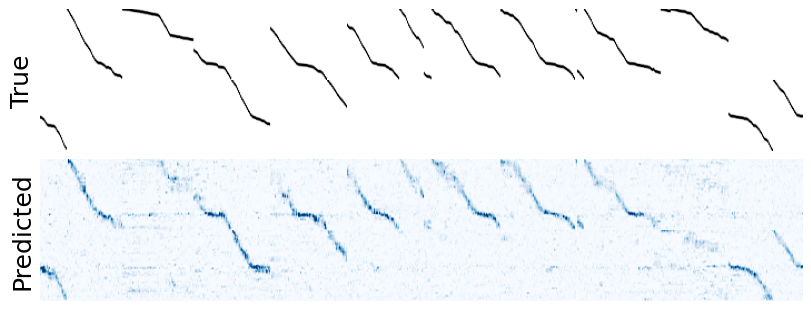

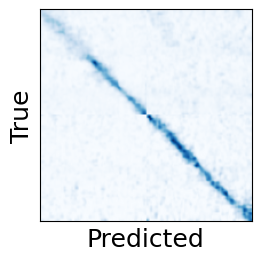

In [17]:
# Example data for RBFPos Models
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = B2Session.create(mouse_name, date, session_id, dict(spks_type=spks_type))

# Model internals for internal placefield model & gain model
hyperparameters = rbfpos_decoder_only_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_decoder = rbfpos_decoder_only_model.process(session, spks_type="oasis", hyperparameters=hyperparameters)

hyperparameters = rbfpos_leak_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_leak = rbfpos_leak_model.process(session, spks_type="oasis", hyperparameters=hyperparameters)

position_basis = report_decoder.extras["position_basis"]
position_basis_leak = report_leak.extras["position_basis"]
position_basis_prediction = report_leak.extras["position_basis_predicted"]
idx_valid_predictions = report_leak.extras["idx_valid_predictions"]
extent_decoder = [0, num_frames, 0, position_basis.shape[1]]
extent_leak = [0, num_frames, 0, position_basis_leak.shape[1]]

vmax = np.max(position_basis_leak) / 2

plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(8, 3), layout="constrained", sharex=True)
ax[0].imshow(position_basis_leak.T, aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent_leak)
ax[1].imshow(position_basis_prediction.T, aspect="auto", cmap="Blues", vmin=0, vmax=vmax, extent=extent_leak)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_ylabel("True")
ax[1].set_ylabel("Predicted")
for spine in ax[0].spines.values():
    spine.set_visible(False)
for spine in ax[1].spines.values():
    spine.set_visible(False)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")
pbleak_norm = position_basis_leak / position_basis_leak.sum(axis=0, keepdims=True)
pbpred_norm = position_basis_prediction / position_basis_prediction.sum(axis=0, keepdims=True)
map_pbasis = np.einsum('bt,ct->bc', pbleak_norm.T, pbpred_norm.T)
map_pbasis = map_pbasis / map_pbasis.sum(axis=1, keepdims=True)
ax.imshow(map_pbasis, aspect="auto", cmap="Blues", vmin=0, vmax=vmax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

In [ ]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
# Separate because RRR_model takes some time to fit
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = B2Session.create(mouse_name, date, session_id, dict(spks_type=spks_type))

hyperparameters_leak = rbfpos_leak_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_leak = rbfpos_leak_model.process(session, spks_type="oasis", hyperparameters=hyperparameters_leak)

hyperparameters_rrr = rrr_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
report_rrr = rrr_model.process(session, spks_type="oasis", hyperparameters=hyperparameters_rrr)

100%|██████████| 149/149 [00:00<00:00, 4406.71it/s]


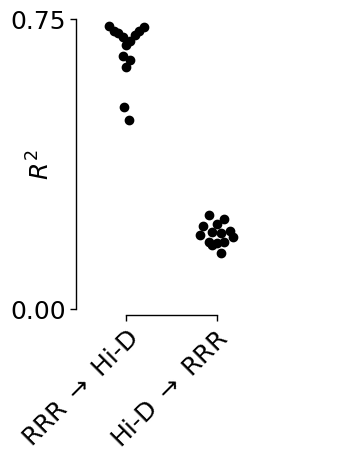

In [112]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
spks_type = "oasis"
rrr_variance = 'match'
normalize = True

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
alpha_rrr_to_pred = np.full((num_sessions,), np.nan)
score_rrr_to_pred = np.full((num_sessions,), np.nan)
alpha_rrr_to_true = np.full((num_sessions,), np.nan)
score_rrr_to_true = np.full((num_sessions,), np.nan)
alpha_pred_to_rrr = np.full((num_sessions,), np.nan)
score_pred_to_rrr = np.full((num_sessions,), np.nan)
alpha_true_to_rrr = np.full((num_sessions,), np.nan)
score_true_to_rrr = np.full((num_sessions,), np.nan)
test_score_rrr_to_pred = np.full((num_sessions,), np.nan)
test_score_rrr_to_true = np.full((num_sessions,), np.nan)
test_score_pred_to_rrr = np.full((num_sessions,), np.nan)
test_score_true_to_rrr = np.full((num_sessions,), np.nan)
for isession, session in enumerate(tqdm(session_iterable)):
    mouse_names.append(session.mouse_name)
    results_fpath = get_rrrlatents_to_rbfpos_filepath(session, rrr_variance, normalize)
    if results_fpath.exists():
        results = joblib.load(results_fpath)
    else:
        continue
    
    alpha_rrr_to_pred[isession] = results["alpha_rrr_to_pred"]
    score_rrr_to_pred[isession] = results["score_rrr_to_pred"]
    alpha_rrr_to_true[isession] = results["alpha_rrr_to_true"]
    score_rrr_to_true[isession] = results["score_rrr_to_true"]
    alpha_pred_to_rrr[isession] = results["alpha_pred_to_rrr"]
    score_pred_to_rrr[isession] = results["score_pred_to_rrr"]
    alpha_true_to_rrr[isession] = results["alpha_true_to_rrr"]
    score_true_to_rrr[isession] = results["score_true_to_rrr"]
    test_score_rrr_to_pred[isession] = results["test_score_rrr_to_pred"]
    test_score_rrr_to_true[isession] = results["test_score_rrr_to_true"]
    test_score_pred_to_rrr[isession] = results["test_score_pred_to_rrr"]
    test_score_true_to_rrr[isession] = results["test_score_true_to_rrr"]
    session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_alpha_rrr_to_pred = np.full((len(mice),), np.nan)
avg_score_rrr_to_pred = np.full((len(mice),), np.nan)
avg_alpha_rrr_to_true = np.full((len(mice),), np.nan)
avg_score_rrr_to_true = np.full((len(mice),), np.nan)
avg_alpha_pred_to_rrr = np.full((len(mice),), np.nan)
avg_score_pred_to_rrr = np.full((len(mice),), np.nan)
avg_alpha_true_to_rrr = np.full((len(mice),), np.nan)
avg_score_true_to_rrr = np.full((len(mice),), np.nan)
avg_test_score_rrr_to_pred = np.full((len(mice),), np.nan)
avg_test_score_rrr_to_true = np.full((len(mice),), np.nan)
avg_test_score_pred_to_rrr = np.full((len(mice),), np.nan)
avg_test_score_true_to_rrr = np.full((len(mice),), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_alpha_rrr_to_pred[imouse] = np.nanmean(alpha_rrr_to_pred[mouse_names == mouse])
    avg_score_rrr_to_pred[imouse] = np.nanmean(score_rrr_to_pred[mouse_names == mouse])
    avg_alpha_rrr_to_true[imouse] = np.nanmean(alpha_rrr_to_true[mouse_names == mouse])
    avg_score_rrr_to_true[imouse] = np.nanmean(score_rrr_to_true[mouse_names == mouse])
    avg_alpha_pred_to_rrr[imouse] = np.nanmean(alpha_pred_to_rrr[mouse_names == mouse])
    avg_score_pred_to_rrr[imouse] = np.nanmean(score_pred_to_rrr[mouse_names == mouse])
    avg_alpha_true_to_rrr[imouse] = np.nanmean(alpha_true_to_rrr[mouse_names == mouse])
    avg_score_true_to_rrr[imouse] = np.nanmean(score_true_to_rrr[mouse_names == mouse])
    avg_test_score_rrr_to_pred[imouse] = np.nanmean(test_score_rrr_to_pred[mouse_names == mouse])
    avg_test_score_rrr_to_true[imouse] = np.nanmean(test_score_rrr_to_true[mouse_names == mouse])
    avg_test_score_pred_to_rrr[imouse] = np.nanmean(test_score_pred_to_rrr[mouse_names == mouse])
    avg_test_score_true_to_rrr[imouse] = np.nanmean(test_score_true_to_rrr[mouse_names == mouse])


data_to_plot = [
    avg_test_score_rrr_to_pred,
    avg_test_score_pred_to_rrr,
    # avg_test_score_rrr_to_true,
    # avg_test_score_true_to_rrr,
]
tick_labels = [
    r"RRR $\rightarrow$ Hi-D",
    r"Hi-D $\rightarrow$ RRR",
    # r"RRR $\rightarrow$ RBFPos",
    # r"RBFPos $\rightarrow$ RRR",
]
tick_positions = [0.5 * i for i in range(len(data_to_plot))]
ymax = np.ceil(20 * np.max(np.stack(data_to_plot))) / 20
bee_width = 0.1
fig, ax = plt.subplots(1, 1, figsize=(3.5, 4.5), layout="constrained")
for i, data in enumerate(data_to_plot):
    ax.plot(0.5 * i + bee_width * beeswarm(data, nbins=4), data, color="k", linestyle="none", marker="o")
ax.set_xlim(-0.25, 0.5 * len(data_to_plot) + 0.25)
ax.set_ylim(0, ymax)
format_spines(
    ax,
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(0, max(tick_positions)),
    ybounds=(0, ymax),
    yticks=[0, ymax],
)
ax.set_xticks(tick_positions, labels=tick_labels, rotation=45, rotation_mode="anchor", ha="right")
ax.set_ylabel("$R^2$", labelpad=-32)
plt.show()

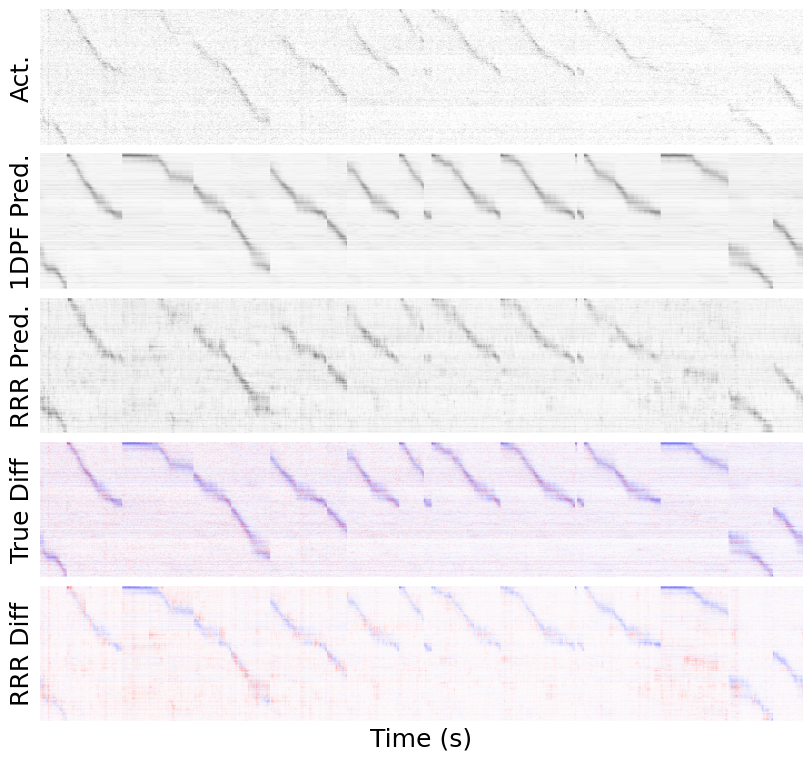

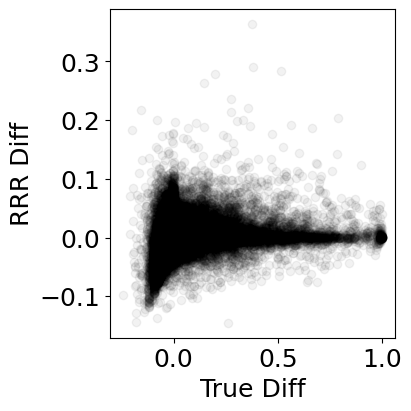

In [26]:
# Let's compare the external model the the RRR model
mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "oasis"
session = B2Session.create(mouse_name, date, session_id, dict(spks_type=spks_type))

ext_hyperparameters = ext_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
ext_report = ext_model.process(session, spks_type="oasis", hyperparameters=ext_hyperparameters)

rrr_hyperparameters = rrr_model.get_best_hyperparameters(session, spks_type="oasis", method="best")[0]
rrr_report = rrr_model.process(session, spks_type="oasis", hyperparameters=rrr_hyperparameters)

# get population object for this session and measure max to rescale
population = ext_model.registry.get_population(session, spks_type="oasis")[0]

use_pfs_to_sort = True
if use_pfs_to_sort:
    idx_rois = population.get_split_cells("target", within_idx_neurons=True)
    idx_sort = sort_by_preferred_environment(SpkmapProcessor(session), use_session_filters=False, idx_rois=idx_rois)
else:
    idx_rois = population.get_split_cells("target", within_idx_neurons=True)
    rastermap = Rastermap(n_PCs=50, n_clusters=25, locality=0.75, time_lag_window=2)
    rastermap.fit(population.data[idx_rois].numpy())
    idx_sort = rastermap.isort

vmax = 0.05
num_rois, num_frames = ext_report.target_data.shape
extent = [0, num_frames, 0, num_rois]
true_diff = ext_report.target_data - ext_report.predicted_data
rrr_diff = rrr_report.predicted_data - ext_report.predicted_data

plt.close('all')
fig, ax = plt.subplots(5, 1, figsize=(8, 7.5), layout="constrained", sharex=True)
ax[0].imshow(ext_report.target_data[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent)
ax[1].imshow(ext_report.predicted_data[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent)
ax[2].imshow(rrr_report.predicted_data[idx_sort], aspect="auto", cmap="gray_r", vmin=0, vmax=vmax, extent=extent)
ax[3].imshow(true_diff[idx_sort], aspect="auto", cmap="bwr", vmin=-vmax, vmax=vmax, extent=extent)
ax[4].imshow(rrr_diff[idx_sort], aspect="auto", cmap="bwr", vmin=-vmax, vmax=vmax, extent=extent)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
ax[4].set_yticks([])
ax[0].set_ylabel("Act.")
ax[1].set_ylabel("1DPF Pred.")
ax[2].set_ylabel("RRR Pred.")
ax[3].set_ylabel("True Diff")
ax[4].set_ylabel("RRR Diff")
for spine in ax[0].spines.values():
    spine.set_visible(False)
for spine in ax[1].spines.values():
    spine.set_visible(False)
for spine in ax[2].spines.values():
    spine.set_visible(False)
for spine in ax[3].spines.values():
    spine.set_visible(False)
for spine in ax[4].spines.values():
    spine.set_visible(False)

ax[4].set_xlabel("Time (s)")
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax.scatter(true_diff.flatten(), rrr_diff.flatten(), color="k", alpha=0.05)
ax.set_xlabel("True Diff")
ax.set_ylabel("RRR Diff")
plt.show()